# Introduction to deep learning for computer vision

**Instantiating a small convnet**

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Displaying the model's summary**

In [2]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

**Training the convnet on MNIST images**

In [3]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
938/938 [==============================] - 15s 6ms/step - loss: 0.1567 - accuracy: 0.9511
Epoch 2/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0442 - accuracy: 0.9859
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0304 - accuracy: 0.9908
Epoch 4/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0227 - accuracy: 0.9928
Epoch 5/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0177 - accuracy: 0.9947


**Evaluating the convnet**

In [4]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0277 - accuracy: 0.9912
Test accuracy: 0.991


### The max-pooling operation

**An incorrectly structured convnet missing its max-pooling layers**

In [5]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712202 (2.72 MB)
Trainable params: 712202 (2.

## Training a convnet from scratch on a small dataset

In [9]:
import gdown

gdown.download(id='18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd', output='dogs-vs-cats.zip')

Downloading...
From (original): https://drive.google.com/uc?id=18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd
From (redirected): https://drive.google.com/uc?id=18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd&confirm=t&uuid=20a2629b-fd84-4bd2-9c3f-25104a3a03c9
To: /content/dogs-vs-cats.zip
100%|██████████| 852M/852M [00:11<00:00, 76.7MB/s]


'dogs-vs-cats.zip'

In [10]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [11]:
!kaggle competitions download -c dogs-vs-cats

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 398, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [12]:
!unzip -qq dogs-vs-cats.zip

In [13]:
!unzip -qq train.zip

**Copying images to training, validation, and test directories**

In [14]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### Building the model

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [16]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                      

**Configuring the model for training**

In [17]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [18]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [19]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [20]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [21]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [22]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [23]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 10s 80ms/step - loss: 0.7335 - accuracy: 0.4980 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 5s 82ms/step - loss: 0.6938 - accuracy: 0.5125 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 6s 83ms/step - loss: 0.6942 - accuracy: 0.5340 - val_loss: 0.6892 - val_accuracy: 0.5230
Epoch 4/30
63/63 [==============================] - 4s 62ms/step - loss: 0.6872 - accuracy: 0.5470 - val_loss: 0.6581 - val_accuracy: 0.6530
Epoch 5/30
63/63 [==============================] - 6s 94ms/step - loss: 0.6468 - accuracy: 0.6255 - val_loss: 0.6583 - val_accuracy: 0.5800
Epoch 6/30
63/63 [==============================] - 4s 56ms/step - loss: 0.6037 - accuracy: 0.6815 - val_loss: 0.6163 - val_accuracy: 0.6550
Epoch 7/30
63/63 [==============================] - 7s 108ms/step - loss: 0.5838 - accuracy: 0.6905 - val_loss: 0.5817 - val_accuracy: 0.6750
Epoch 8/30


**Displaying curves of loss and accuracy during training**

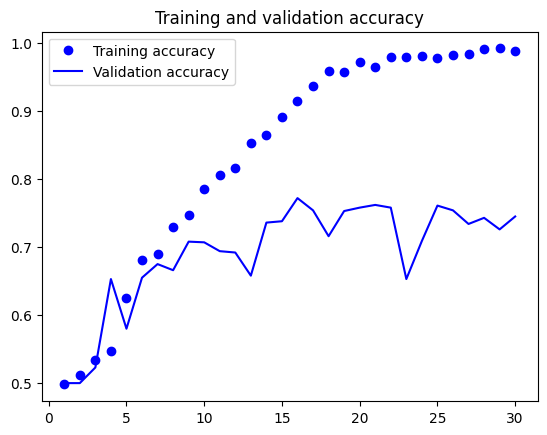

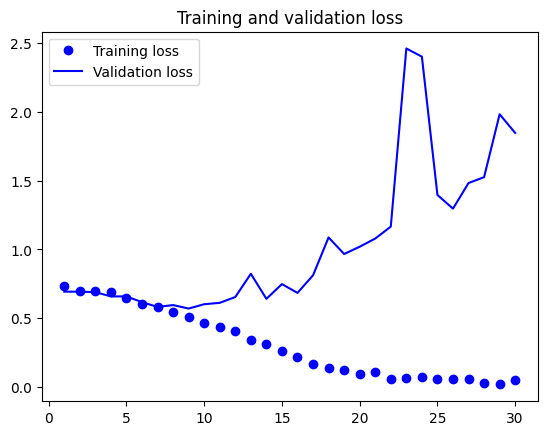

In [25]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [26]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 32ms/step - loss: 0.5708 - accuracy: 0.7090
Test accuracy: 0.709


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [27]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

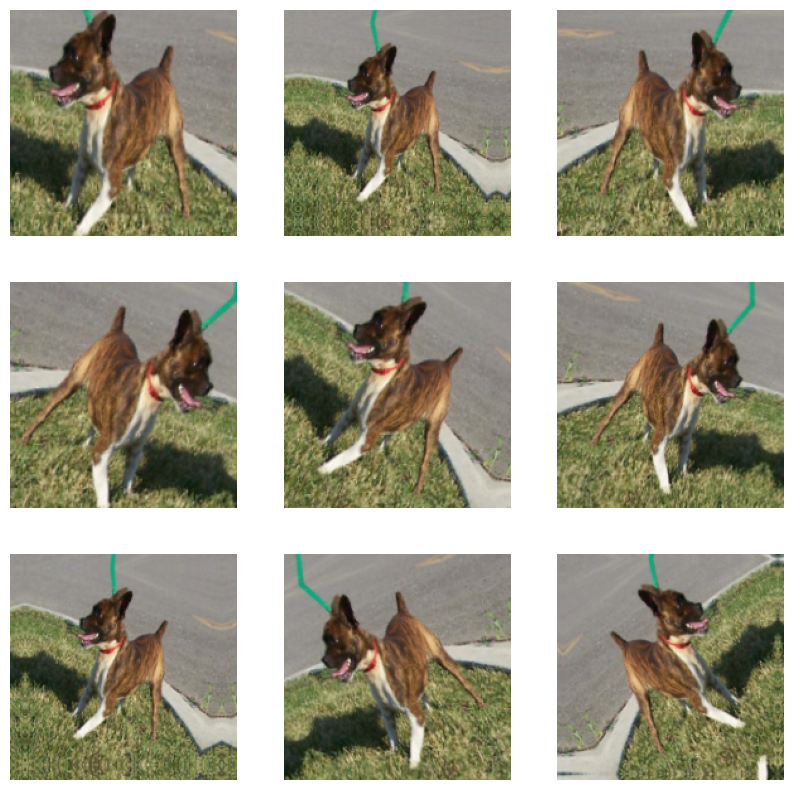

In [28]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [29]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [30]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 10s 105ms/step - loss: 0.6963 - accuracy: 0.4980 - val_loss: 0.6924 - val_accuracy: 0.5030
Epoch 2/100
63/63 [==============================] - 4s 60ms/step - loss: 0.6937 - accuracy: 0.5065 - val_loss: 0.6906 - val_accuracy: 0.5660
Epoch 3/100
63/63 [==============================] - 4s 58ms/step - loss: 0.6908 - accuracy: 0.5410 - val_loss: 0.9725 - val_accuracy: 0.5010
Epoch 4/100
63/63 [==============================] - 6s 91ms/step - loss: 0.6814 - accuracy: 0.5725 - val_loss: 0.6721 - val_accuracy: 0.5720
Epoch 5/100
63/63 [==============================] - 4s 59ms/step - loss: 0.6594 - accuracy: 0.6270 - val_loss: 0.6547 - val_accuracy: 0.5880
Epoch 6/100
63/63 [==============================] - 5s 84ms/step - loss: 0.6280 - accuracy: 0.6430 - val_loss: 0.5975 - val_accuracy: 0.6820
Epoch 7/100
63/63 [==============================] - 4s 58ms/step - loss: 0.6176 - accuracy: 0.6735 - val_loss: 0.6365 - val_accuracy: 0.6560
Epoc

**Evaluating the model on the test set**

In [31]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 57ms/step - loss: 0.4402 - accuracy: 0.8120
Test accuracy: 0.812


## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the VGG16 convolutional base**

In [32]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [33]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [34]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 32ms/step


In [35]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [36]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 16.5230 - accuracy: 0.9200 - val_loss: 3.0323 - val_accuracy: 0.9730
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 2.6878 - accuracy: 0.9800 - val_loss: 4.1851 - val_accuracy: 0.9680
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 2.0249 - accuracy: 0.9830 - val_loss: 4.2076 - val_accuracy: 0.9720
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.2471 - accuracy: 0.9900 - val_loss: 6.7751 - val_accuracy: 0.9630
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 0.7718 - accuracy: 0.9935 - val_loss: 3.8233 - val_accuracy: 0.9780
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 0.9828 - accuracy: 0.9920 - val_loss: 4.5418 - val_accuracy: 0.9760
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 1.0089 - accuracy: 0.9935 - val_loss: 3.8915 - val_accuracy: 0.9760
Epoch 8/20
63/63 [

**Plotting the results**

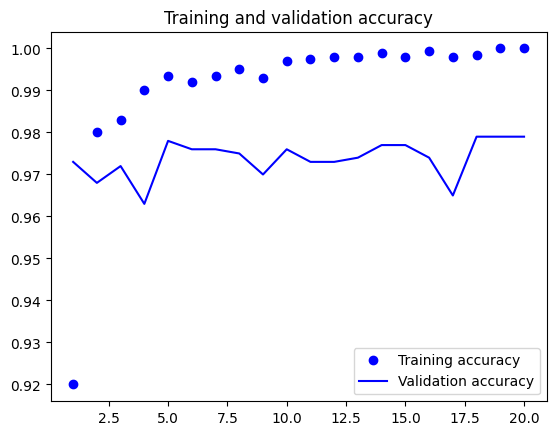

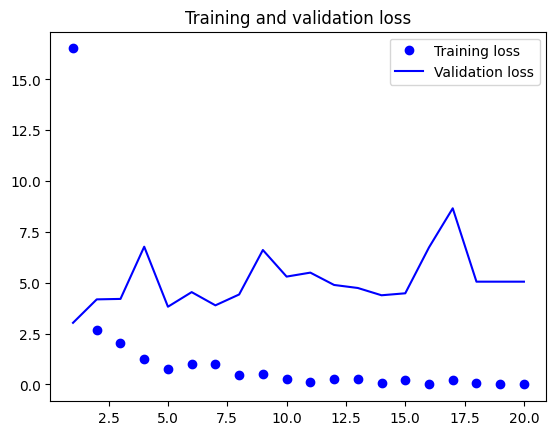

In [37]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [38]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [39]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [40]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [41]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])